Using device: cpu


100%|██████████| 170M/170M [00:01<00:00, 95.4MB/s]



Training VGG...
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 156MB/s]


VGG Epoch 1: Val Acc = 32.50%
VGG Epoch 2: Val Acc = 52.50%

Training RESNET...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s]


RESNET Epoch 1: Val Acc = 35.00%
RESNET Epoch 2: Val Acc = 50.00%

Training GOOGLENET...
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 154MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


GOOGLENET Epoch 1: Val Acc = 15.00%
GOOGLENET Epoch 2: Val Acc = 17.50%


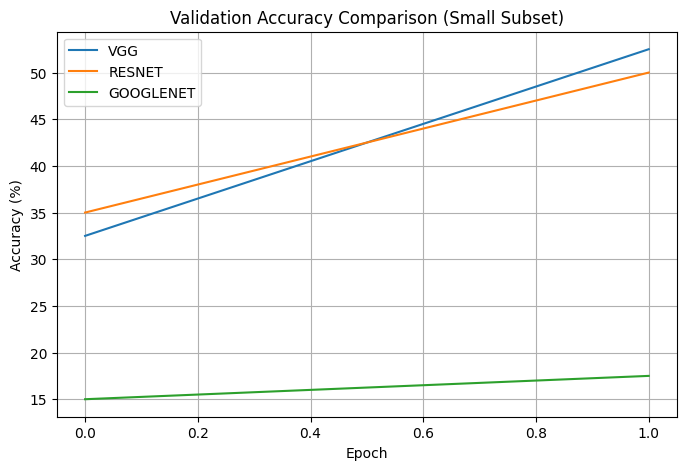

In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# Data
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=transform)

# Use smaller subset for CPU speed
subset = Subset(train_data, range(200))
train_size = int(0.8*len(subset)); val_size = len(subset)-train_size
train_set, val_set = random_split(subset,[train_size,val_size])
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=16)

# Train & Eval
def train_and_eval(model, name, epochs=2):
    model.to(device)
    crit, opt = nn.CrossEntropyLoss(), optim.Adam(model.parameters(), lr=1e-4)
    val_accs = []
    for e in range(epochs):
        model.train()
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            if isinstance(out, tuple) or hasattr(out, "logits"):  # GoogLeNet
                out = out.logits if hasattr(out,"logits") else out[0]
            loss = crit(out, y)
            loss.backward(); opt.step()
        # validation
        model.eval(); correct=total=0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(device), y.to(device)
                out = model(x)
                if isinstance(out, tuple) or hasattr(out, "logits"):
                    out = out.logits if hasattr(out,"logits") else out[0]
                preds = out.argmax(1)
                correct += (preds==y).sum().item(); total += y.size(0)
        acc = 100*correct/total; val_accs.append(acc)
        print(f"{name} Epoch {e+1}: Val Acc = {acc:.2f}%")
    return val_accs


# Pretrained models (freeze backbone)
def get_model(name):
    if name=="vgg":
        m = models.vgg16(weights="IMAGENET1K_V1")
        for p in m.features.parameters(): p.requires_grad=False
        m.classifier[6]=nn.Linear(4096,10)
    elif name=="resnet":
        m = models.resnet18(weights="IMAGENET1K_V1")
        for p in m.layer1.parameters(): p.requires_grad=False
        m.fc=nn.Linear(m.fc.in_features,10)
    elif name=="googlenet":
        m = models.googlenet(weights="IMAGENET1K_V1", aux_logits=True)
        for p in m.parameters(): p.requires_grad=False
        m.fc=nn.Linear(m.fc.in_features,10)
    return m

# Train all
results={}
for name in ["vgg","resnet","googlenet"]:
    print(f"\nTraining {name.upper()}...")
    model = get_model(name)
    results[name] = train_and_eval(model, name.upper())

# Plot
plt.figure(figsize=(8,5))
for name, accs in results.items():
    plt.plot(accs, label=f"{name.upper()}")
plt.title("Validation Accuracy Comparison (Small Subset)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.legend(); plt.grid(); plt.show()